In [1]:
import gpn.model
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from transformers import AutoModel, AutoModelForMaskedLM, AutoTokenizer
import h5py
import numpy as np
import os
import sys
import pickle as pkl
from scipy.special import softmax
import scipy.stats as stats
sys.path.append('../data_generation/')
import utils
import interp_utils
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

model = AutoModelForMaskedLM.from_pretrained("../model/GPN_human/checkpoint-2000000").to('cuda')
tokenizer = AutoTokenizer.from_pretrained("../model/GPN_human/checkpoint-2000000")
model.eval();

count = 3

/home/ztang/.conda/envs/gpn_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def mask_seq_by_token(top_x,tokenizer):
    seq = utils.onehot_to_seq(top_x)
    input_ids = tokenizer(seq, return_attention_mask=False, return_token_type_ids=False)["input_ids"]
    m_seq_list = []
    for s in input_ids:
        for i in range(len(s)):
            m_seq = np.copy(s)
            m_seq[i] = 0
            m_seq_list.append(m_seq)
    m_seq_list = np.array(m_seq_list)
    return m_seq_list
    
def predict_p_matrix(model,m_seq_list):
    N,L = m_seq_list.shape
    logit_matrix = np.zeros((N//L,L,4))
    for i in range(N//L):
        batch = m_seq_list[i*L:(i+1)*L]
        output = model(torch.from_numpy(batch).to('cuda'))['logits'].cpu().detach().numpy()
        for loc in range(L):
            logit_matrix[i,loc] = output[loc,loc,2:]
    p_matrix = softmax(logit_matrix,axis=-1)
    entropy = stats.entropy(p_matrix,axis=-1)
    return p_matrix,entropy
    
def mutiply_cnn_saliency(entropy,p_matrix,saliency,top_x,plot_count=None):
    sal_entropy = entropy * saliency  
    if plot_count is not None:
        interp_utils.plot_value_per_loc(top_x[:plot_count],sal_entropy[:plot_count])
    
    return sal_entropy,entropy


## CHIP

In [3]:
exp = 'CTCF'
top_x = np.load('./top_seq/chip/'+exp+'.npz')['arr_0']
top_x = np.swapaxes(top_x,1,2)
## Make predictions with GPN
m_seq_list = mask_seq_by_token(top_x,tokenizer)
p_matrix,entropy = predict_p_matrix(model,m_seq_list)
saliency = np.load('./top_saliency/GPN_downstream/chip/'+exp+'.npz')['arr_0']


/home/ztang/.conda/envs/gpn_env/lib/python3.9/site-packages/torch/nn/modules/conv.py:309: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv1d(input, weight, bias, self.stride,


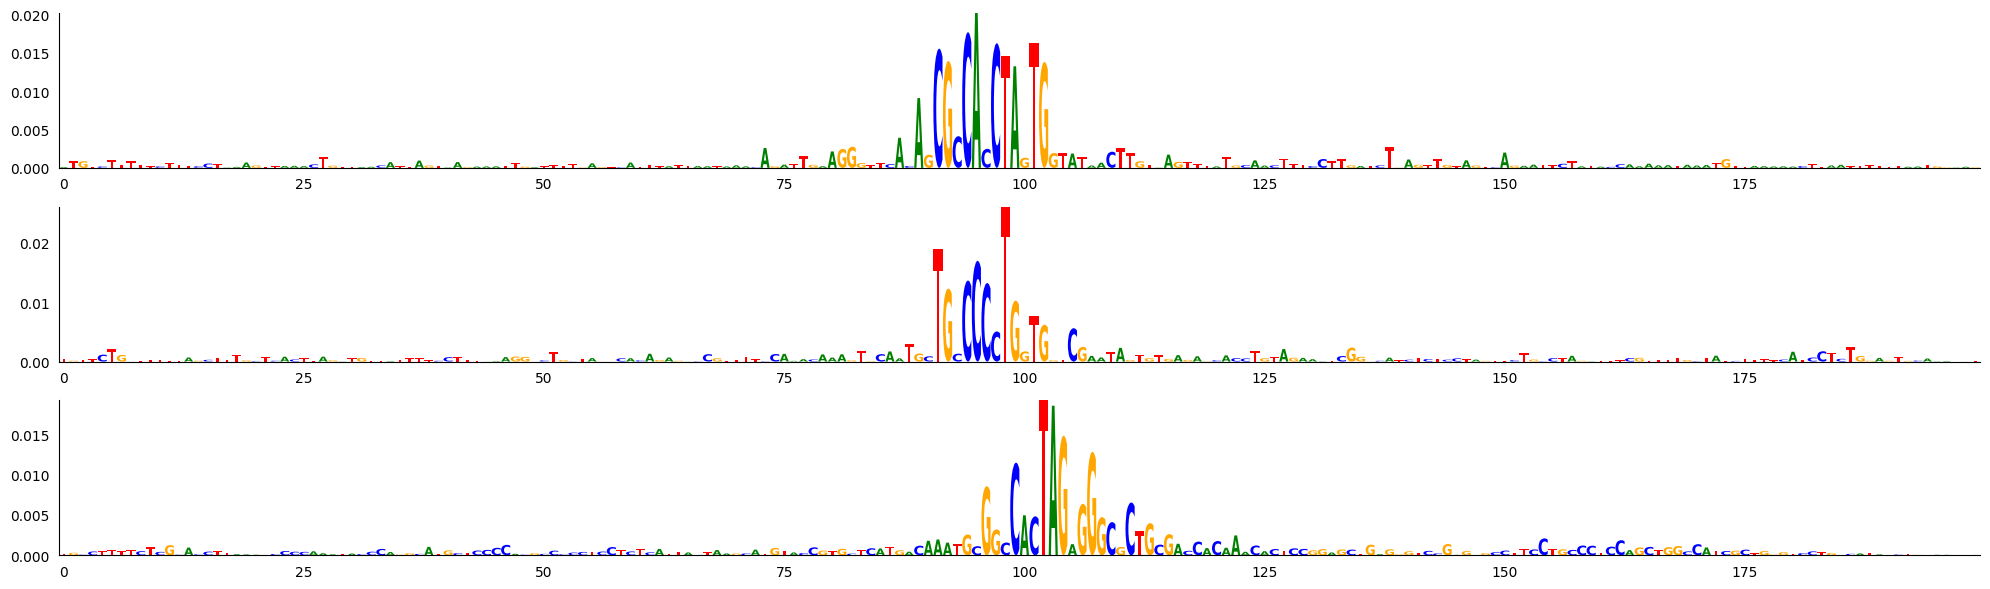

In [4]:
# Considering gradient of downstream model
reverse_e = np.max(entropy) - entropy
sal_e,lm_e = mutiply_cnn_saliency(reverse_e,p_matrix,saliency,top_x,count)
np.savez('./top_saliency/gpn_chip_'+exp+'.npz',lm_e,sal_e)

## INSERT

In [5]:
top_x = np.load('./top_seq/insert.npz')['arr_0']
top_x = np.swapaxes(top_x,1,2)
## Make predictions with GPN
m_seq_list = mask_seq_by_token(top_x,tokenizer)
p_matrix,entropy = predict_p_matrix(model,m_seq_list)
reverse_e = np.max(entropy) - entropy
saliency = np.load('./top_saliency/GPN_downstream/insert.npz')['arr_0']

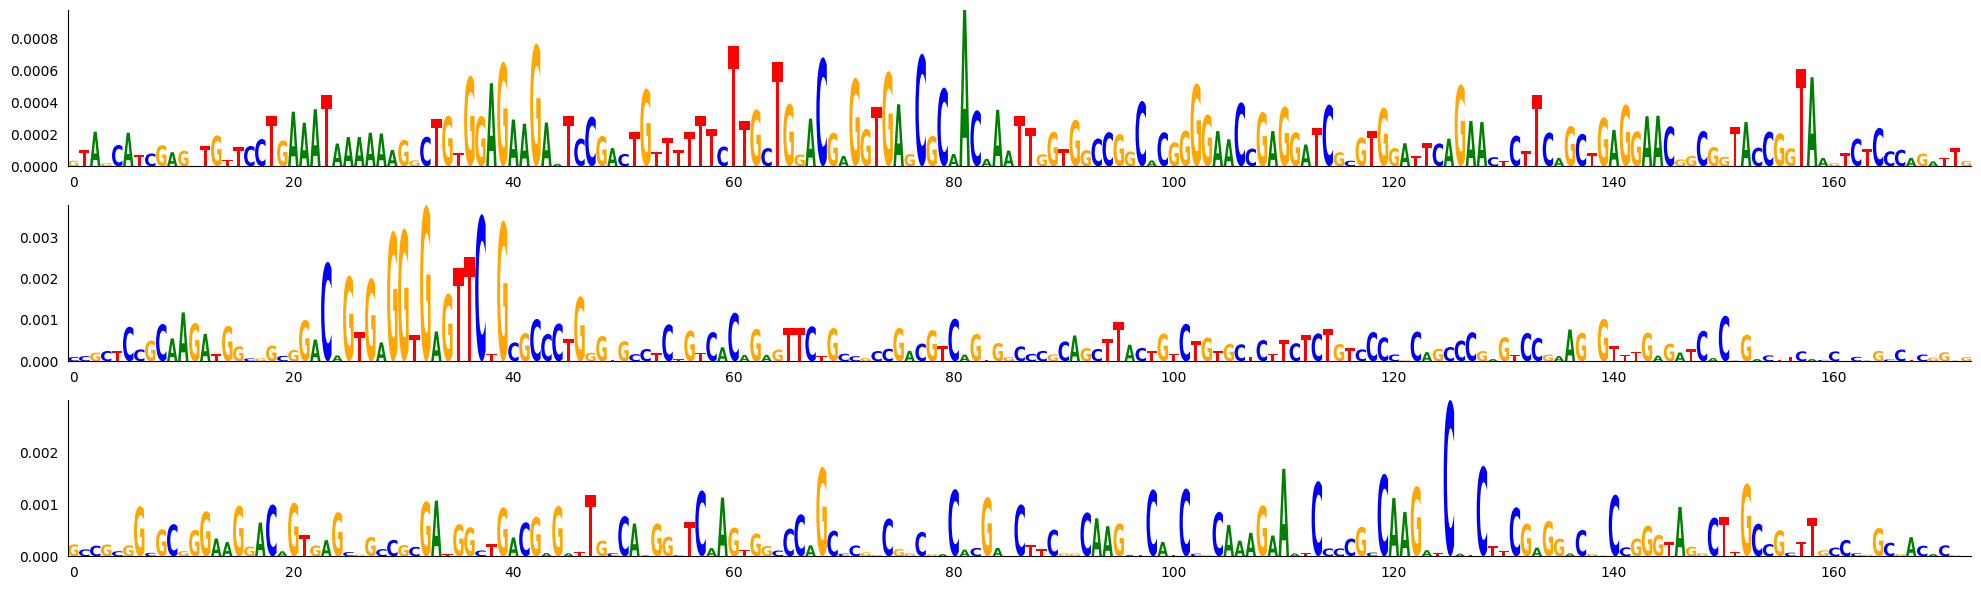

In [6]:
# Considering gradient of downstream model
reverse_e = np.max(entropy) - entropy
sal_e,lm_e = mutiply_cnn_saliency(reverse_e,p_matrix,saliency,top_x,count)
np.savez('./top_saliency/gpn_insert.npz',lm_e,sal_e)

## CLIP

In [7]:
# eClip data
exp = 'TIA1'
top_x = np.load('./top_seq/clip/'+exp+'.npz')['arr_0']
top_x = np.swapaxes(top_x,1,2)
## Make predictions with GPN
m_seq_list = mask_seq_by_token(top_x,tokenizer)
p_matrix,entropy = predict_p_matrix(model,m_seq_list)
saliency = np.load('./top_saliency/GPN_downstream/clip/'+exp+'.npz')['arr_0']

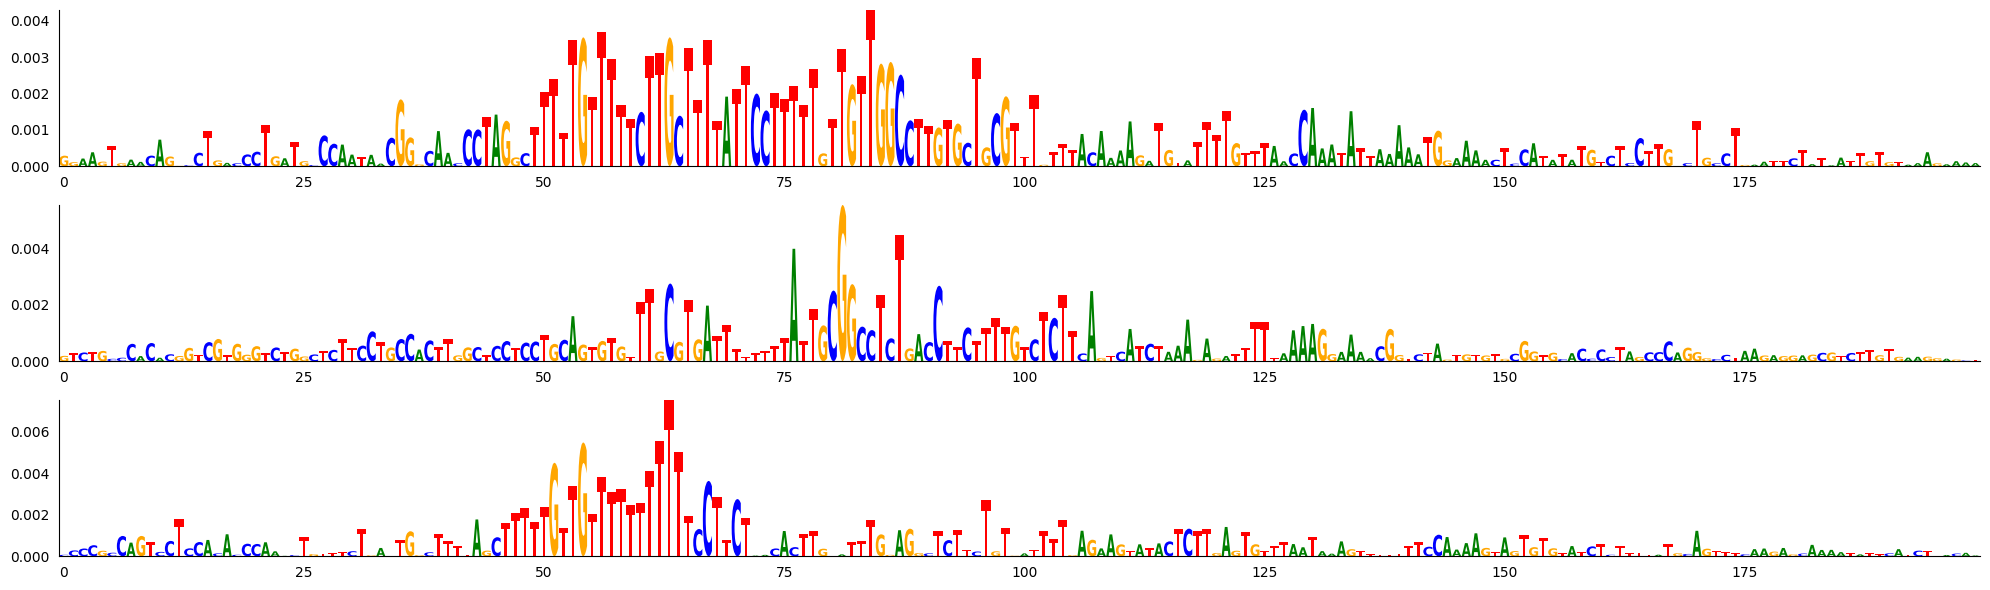

In [8]:
# Considering gradient of downstream model
reverse_e = np.max(entropy) - entropy
sal_e,lm_e = mutiply_cnn_saliency(reverse_e,p_matrix,saliency,top_x,count)
np.savez('./top_saliency/gpn_clip_'+exp+'.npz',lm_e,sal_e)

## Lenti

In [11]:
from sklearn import model_selection
ct = 'HepG2'
top_x = np.load('./top_seq/lenti_'+ct+'.npz')['arr_0']
top_x = np.swapaxes(top_x,1,2)
## Make predictions with GPN
m_seq_list = mask_seq_by_token(top_x,tokenizer)
p_matrix,entropy = predict_p_matrix(model,m_seq_list)
saliency = np.load('./top_saliency/GPN_downstream/lenti_'+ct+'.npz')['arr_0']

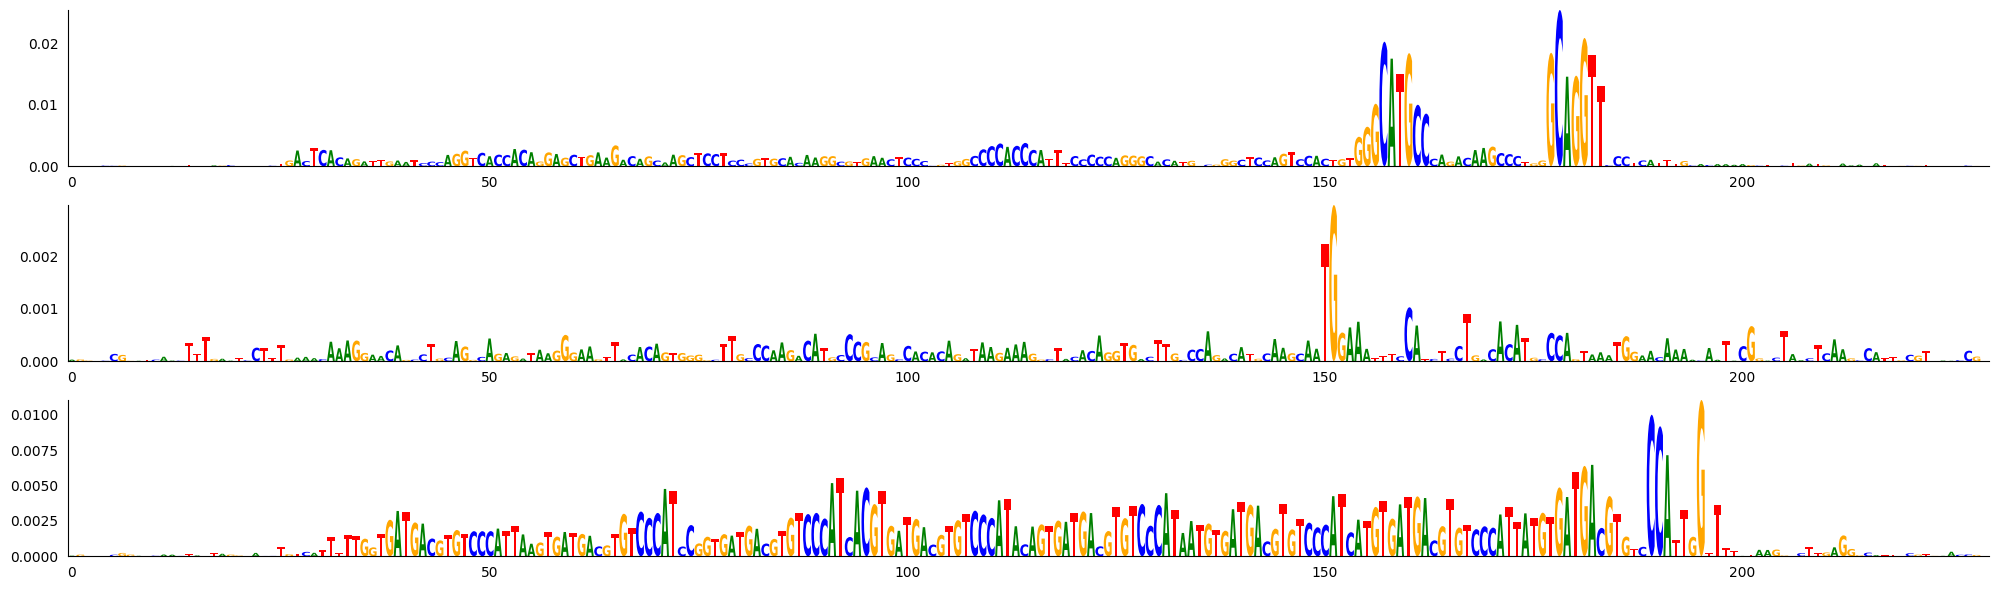

In [12]:
# Considering gradient of downstream model
reverse_e = np.max(entropy) - entropy
sal_e,lm_e = mutiply_cnn_saliency(reverse_e,p_matrix,saliency,top_x,count)
np.savez('./top_saliency/gpn_lenti_'+ct+'.npz',lm_e,sal_e)